# NLP on Yelp Open Dataset for Review Classification

Questo notebook ha il compito di effettuare tramite NLP una classificazione delle reviews in positive e negative andando ad analizzare testi tokenizzati all'interno del dataset fornito da Open Yelp Dataset. Ci soffermeremo solamente sulla tabella dedicata alla review poichè si giudicano sufficiente, per raggiungere un livello di precisione accettabile, le informazioni contenute all'interno delle colonne della tabella review fornita in input.

### Import Libraries

In [34]:
# librerie di default
import pandas as pd
import numpy as np

# librerie per il data analysis
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

import nltk as nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('punkt')

# librerie per il data pre-processing
from collections import Counter
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# librerie per il data modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

[nltk_data] Downloading package punkt to /Users/kode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data Loading

La fase di data loading non fa altro che caricare all'interno di un pandas dataframe le informazioni contenute nel dataset JSON in formato tabellare per poi utilizzarlo nella fase di data analysis per visualizzare le correlazioni e i valori al suo interno tramite visualizzazione grafica in modo da rendersi conto di che tipo e in che quantità sono distribuiti i dati.

In [2]:
# definiamo i tipi degli attributi JSON per l'attributo dtype di read_json
rtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
            "text" : str,
           }

# file path del dataset json
path = './data/yelp_academic_dataset_review.json'

# grandezza dei chunk
chunkSize = 100000

In [3]:
%%time
# creazione del JsonReader
review = pd.read_json(path, lines=True,
                      dtype=rtypes,
                      chunksize=chunkSize)
chunkList = []

# utilizzo della segmentazione in chunk per creare dal JsonReader il dataframe
for chunkReview in review:
    # rimozione degli attributi id
    chunkReview = chunkReview.drop(['review_id', 'user_id','business_id'], axis=1)
    chunkList.append(chunkReview)
    
# concatenazione degli elementi nella chunkList per righe
df = pd.concat(chunkList, ignore_index=True, axis=0)

CPU times: user 1min 21s, sys: 16.3 s, total: 1min 37s
Wall time: 1min 38s


In [4]:
# visualizzazione degli elementi in testa
df.head()

,stars,useful,funny,cool,text,date
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


## 2. Data Analysis

Durante la fase di data analysis andremo ad ispezionare il dataframe caricato andando a visualizzare graficamente come sono distribuiti i valori associati ad ogni attributo.

In [5]:
# informazioni sulle colonne del dataframe e su quante entries o righe si hanno
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   stars   float16       
 1   useful  int32         
 2   funny   int32         
 3   cool    int32         
 4   text    object        
 5   date    datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(1)
memory usage: 247.1+ MB


### 2.1 Stars Analysis

Text(0.5, 1.0, "Distribuzione dei valori per l'attributo stars")

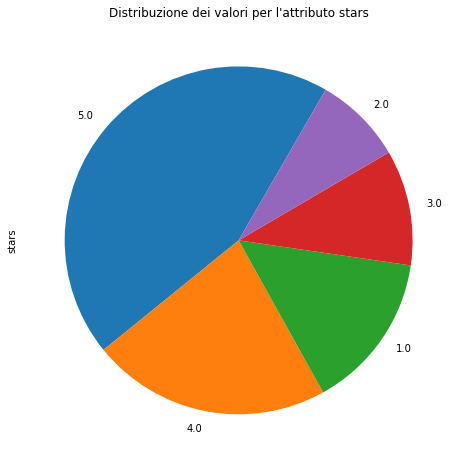

In [6]:
# definire la grandezza della figura
plt.figure(figsize=(8,8))

# contare i vari valori di stars e visualizzarli su un diagramma a torta
df['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori per l\'attributo stars')

Le quantità di recensioni, classificate in base al numero di stelle assegnate, è sbilanciata. Si ha un maggior numero per le recensioni con 5 e 4 stelle rispetto a quelle con 1, 2 o 3 stelle.

<AxesSubplot:>

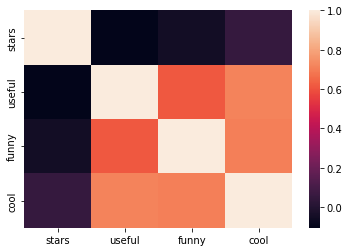

In [7]:
# definire le correlazioni
corr = df.corr()

# generazione dell'heatmap
sns.heatmap(corr)

Non sono presenti particolari correlazioni forti tra i funny, useful e cool con i valori dati a stars.

### Text Analysis

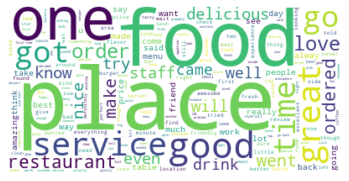

CPU times: user 21.6 s, sys: 865 ms, total: 22.4 s
Wall time: 22.4 s


In [8]:
%%time

# definisce un sottoinsieme delle righe del dataset
subset = df[:100000]
# concatenazione dei testi di ogni riga in una singola stringa
inputText = ' '.join(subset['text']).lower()

# creazione di un wordcloud andando ad ignorare le stopwords
wordCloud = WordCloud(background_color='white', stopwords=STOPWORDS).generate(inputText)
# setting della visualizzazione utilizzando una interpolazione bilineare
plt.imshow(wordCloud, interpolation='bilinear')

# rimozione degli assi
plt.axis('off')
# visualizzazione del wordcloud rappresentante le parole più usate nel testo di una recensione
plt.show()

In [9]:
# calcolo della frequenza dei termini più utilizzati
wordTokens = word_tokenize(inputText)
tokens = list()
for word in wordTokens:
    if word.isalpha() and word not in STOPWORDS:
        tokens.append(word)
tokenDist = FreqDist(tokens)
# per questioni di visualizzazione, andiamo a prendere solamente i primi 20 termini utilizzati
dist = pd.DataFrame(tokenDist.most_common(20),columns=['term', 'freq'])

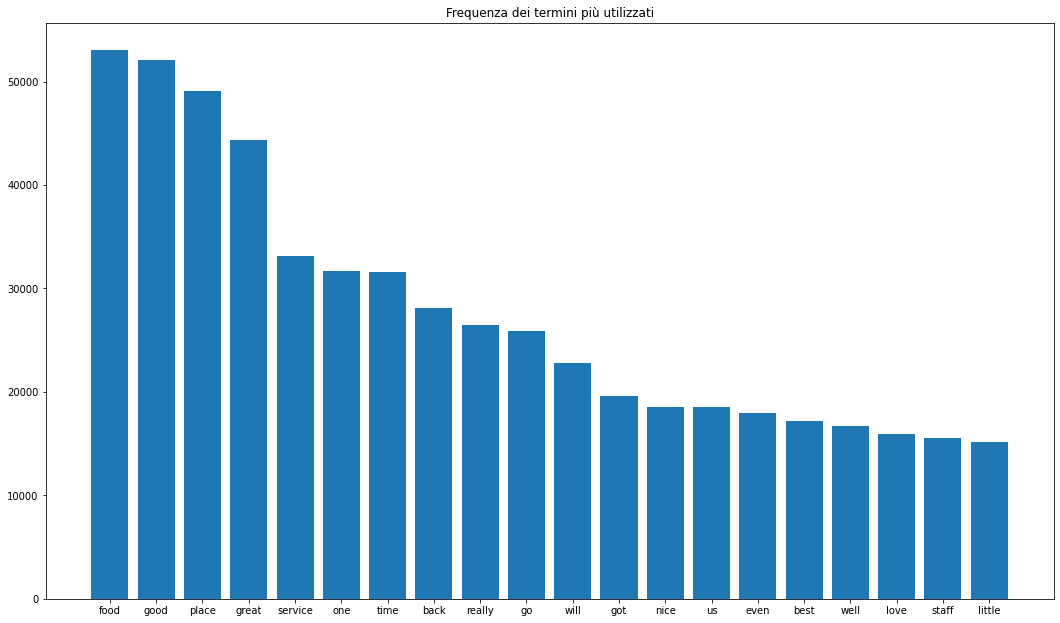

In [10]:
# rappresentazione grafica dei risultati
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x = dist['term']
y = dist['freq']
ax.bar(x,y)
plt.title('Frequenza dei termini più utilizzati')
plt.show()

In [11]:
# Aggiunta di una feature per l'analisi della lunghezza dei testi
df['textLength']  = df['text'].str.len()

In [12]:
df.head()

,stars,useful,funny,cool,text,date,textLength
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


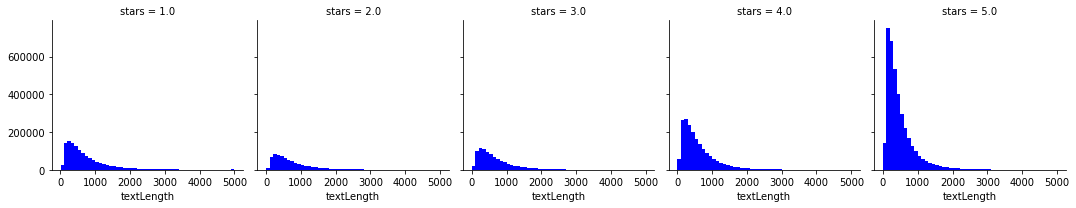

In [13]:
# Differenziazione della lunghezza dei testi in relazione alla valutazione data a stars
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'textLength',bins=50,color='blue')

## 3. Data Pre-processing

Durante la fase di pre-processing, andiamo a pulire e bilanciare il dataframe in modo da poterlo utilizzare per il data modelling.

In [14]:
# cancellazione delle caratteristiche cool, funny, useful e textLength poichè non hanno correlazioni con stars.
df = df.drop(['cool', 'funny', 'useful', 'textLength'], axis=1)

In [15]:
df.head()

,stars,text,date
0,4.0,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [16]:
# polarizzazione delle valutazioni a stars in due categorie: 1 = positiva, 0 = negativa

# isoliamo la colonna di testo del dataframe in texts
texts =  df['text']

# andiamo ad impostare negative tutte le recensioni con 3 o meno stelle e positive quelle con 4 e 5 stelle.
stars = [0 if star <= 3.0 else 1 for star in df['stars']]

balancedTexts = [] # rappresenta la collezione di testi presi in considerazione dal dataframe di input
balancedLabels = [] # rappresenta il nuovo valore polarizzato assegnato all'entry (0,1)

# andiamo a bilanciare il dataset andando a dividere recensioni positive e negative con limite di 1.000.000 per categoria
limit = 100000  

# posizione 0 per conteggio di recensioni negative, posizione 1 per quelle positive
negPosCounts = [0, 0] 

for i in range(0,len(texts)):
    polarity = stars[i]
    if negPosCounts[polarity] < limit: # se non si è raggiunto il limite per la categoria di polarizzazione
        balancedTexts.append(texts[i])
        balancedLabels.append(stars[i])
        negPosCounts[polarity] += 1

In [17]:
# verifica del conteggio
counter = Counter(balancedLabels)
print(f'Ci sono {counter[1]} recensioni positive e {counter[0]} recensioni negative')

Ci sono 100000 recensioni positive e 100000 recensioni negative


### 3.1 Text Tokenization

In [51]:
%%time
# definizione di un tokenizer di 25.000 parole prese dal dataframe
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(balancedTexts)
# trasformazione del testo in sequenze di interi in modo da valutare più velocemente le parole
sequences = tokenizer.texts_to_sequences(balancedTexts)
# Sequenze di massimo 250 unità. Se vi sono testi con sequenze più lunghe esse vengono troncate, altrimenti si avrà 
# un riempimenti di 0 per testi undersized.
data = pad_sequences(sequences, maxlen=250) 

CPU times: user 26.4 s, sys: 798 ms, total: 27.2 s
Wall time: 27.3 s


## 4. Data Modelling

In [57]:
# Checking sulle compile flags di tensorflow
print(tf.sysconfig.get_compile_flags())
print(tf.__version__)

['-I/usr/local/lib/python3.9/site-packages/tensorflow/include', '-D_GLIBCXX_USE_CXX11_ABI=0', '-DEIGEN_MAX_ALIGN_BYTES=64']
2.6.0


In [54]:
# train and test splitting
x_train, x_test, y_train, y_test = train_test_split(data, np.array(balancedLabels), random_state=64)

In [61]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
model_lstm = keras.Sequential()

# aggiunta dei layers
model_lstm.add(layers.Embedding(25000, 128, input_length=250))
model_lstm.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)) # dropout dentro il layer LSTM
model_lstm.add(layers.Dense(1, activation='sigmoid'))

model_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 128)          3200000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,331,713
Trainable params: 3,331,713
Non-trainable params: 0
_________________________________________________________________


In [62]:
results_lstm = model_lstm.fit(x_train, y_train, validation_split=0.33, epochs=3)

Epoch 1/3
3141/3141 [==============================] - 1146s 364ms/step - loss: 0.3326 - accuracy: 0.8584 - val_loss: 0.2744 - val_accuracy: 0.8861
Epoch 2/3
3141/3141 [==============================] - 1252s 399ms/step - loss: 0.2387 - accuracy: 0.9052 - val_loss: 0.2672 - val_accuracy: 0.8913
Epoch 3/3
3141/3141 [==============================] - 1179s 375ms/step - loss: 0.1903 - accuracy: 0.9261 - val_loss: 0.2878 - val_accuracy: 0.8871


In [63]:
model_lstm.evaluate(x_test, y_test)

1563/1563 [==============================] - 68s 43ms/step - loss: 0.2879 - accuracy: 0.8870


[0.2879026532173157, 0.8870000243186951]

modelLSTM.evaluate(xTest, yTest)

In [64]:
model_lstm_v2 = keras.Sequential()
model_lstm_v2.add(layers.Embedding(25000, 128, input_length=250))
model_lstm_v2.add(layers.Dropout(0.5)) # layer di dropout esterno in seguito ad Embedding
model_lstm_v2.add(layers.Conv1D(64, 5, activation='relu'))
model_lstm_v2.add(layers.MaxPooling1D(pool_size=4))
model_lstm_v2.add(layers.LSTM(128))
model_lstm_v2.add(layers.Dense(1, activation='sigmoid'))


model_lstm_v2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_lstm_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 128)          3200000   
_________________________________________________________________
dropout (Dropout)            (None, 250, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 246, 64)           41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 61, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,339,969
Trainable params: 3,339,969
Non-trainable params: 0
____________________________________________

In [65]:
model_lstm_v2.fit(x_train, y_train, validation_split=0.33, epochs=5)

Epoch 1/5
3141/3141 [==============================] - 286s 90ms/step - loss: 0.3110 - accuracy: 0.8672 - val_loss: 0.2578 - val_accuracy: 0.8908
Epoch 2/5
3141/3141 [==============================] - 4006s 1s/step - loss: 0.2280 - accuracy: 0.9075 - val_loss: 0.2782 - val_accuracy: 0.8792
Epoch 3/5
3141/3141 [==============================] - 277s 88ms/step - loss: 0.1852 - accuracy: 0.9263 - val_loss: 0.2681 - val_accuracy: 0.8882
Epoch 4/5
3141/3141 [==============================] - 277s 88ms/step - loss: 0.1495 - accuracy: 0.9414 - val_loss: 0.3143 - val_accuracy: 0.8846
Epoch 5/5
3141/3141 [==============================] - 572s 182ms/step - loss: 0.1233 - accuracy: 0.9519 - val_loss: 0.3191 - val_accuracy: 0.8838


In [66]:
model_lstm_v2.evaluate(x_test, y_test)

1563/1563 [==============================] - 24s 15ms/step - loss: 0.3227 - accuracy: 0.8852


[0.322697252035141, 0.885200023651123]

In [67]:
model_bid = keras.Sequential()
model_bid.add(layers.Embedding(25000, 128, input_length=250))
model_bid.add(layers.Dropout(0.5))
model_bid.add(layers.Conv1D(64, 5, activation='relu'))
model_bid.add(layers.Bidirectional(LSTM(128)))
model_bid.add(layers.Dense(1, activation='sigmoid'))
model_bid.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_bid.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 128)          3200000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 3,438,913
Trainable params: 3,438,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_bid.fit(x_train, y_train, validation_split=0.33, epochs=3)

Epoch 1/3
3141/3141 [==============================] - 731s 231ms/step - loss: 0.3366 - accuracy: 0.8581 - val_loss: 0.2765 - val_accuracy: 0.8872
Epoch 2/3
3141/3141 [==============================] - 825s 263ms/step - loss: 0.2409 - accuracy: 0.9035 - val_loss: 0.2592 - val_accuracy: 0.8933
Epoch 3/3
2049/3141 [==================>...........] - ETA: 6:27:37 - loss: 0.2006 - accuracy: 0.9213

In [ ]:
model_bid.evaluate(xTest,yTest)

## 5. Model Testing

In [ ]:
## 4.2 Save model

In [ ]:
import pickle

# salviamo il tokenizer e i modelli su file
with open("dump/keras_tokenizer.pickle", "wb") as f:
   pickle.dump(tokenizer, f)
with open("dump/tokenizer/yelp_model_lstm.hdf5","wb") as lstm_file:
    model_lstm.save(lstm_file)
          
with open("dump/model/yelp_model_lstm_v2.hdf5", "wb") as lstm_v2_file:
    model_lstm_v2.save(lstm_v2_file)
    
with open("dump/model/yelp_bidirectional.hdf5", "wb") as bid_file:
    model_bid.save(bid_file)

In [ ]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

# carichiamo il tokenizer e il modello da file
with open("keras_tokenizer.pickle", "rb") as f:
   tokenizer = pickle.load(f)

# TODO: load other models
model_lstm = load_model("dump/model/yelp_model_lstm.hdf5")
model_lstm_v2 = load_model("dump/model/yelp_model_lstm_v2.hdf5")
model_bid = load_model("dump/model/yelp_bidirectional.hdf5")

# definiamo gli esempi su cui testare il modello
examples_reviews = ["slow orders but good food", "Delicious foods! Awesome!", "Bad food, bad people... horrible!"]

# usiamo il tokenizer per creare sequenze di interi da dare al modello
sequences = tokenizer.texts_to_sequences(examples_reviews)
data_examples = pad_sequences(sequences, maxlen=250)

# effettuare le predizioni e stampare i risultati
predictions_lstm = model_lstm.predict(data_examples)
predictions_lstm_v2 = model_lstm_v2.predict(data_examples)
predictions_bid = model_bid.predict(data_examples)

print(f"Risultati model_lstm: {predictions_lstm}\n"+
    f"Risultati model_lstm_v2: {predictions_lstm_v2}\n" + 
      f"Risultati model_bid: {predictions_bid}")

In [ ]:
# TODO: Data Analytics sui risultati